# Static Ordinal Regression with Diabetes toy dataset using TensorFlow
---------

## Imports

In [1]:
# General
import sys, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# sklearn
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer, KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix

In [2]:
# tensorflow
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import bijectors as tfb
from tensorflow.keras.optimizers import Adam

In [3]:
# local
sys.path.append(os.path.abspath(os.path.join('../src')))
from clm_tensorflow.cumulative_link import CumulativeLink
from clm_tensorflow.negative_log_likelihood import NegativeLogLikelihood

## Data Preprocessing

In [4]:
# Set the random state and desired number of classes
random_state = 1
n_classes = 5

In [5]:
# Load Data
X, y = load_diabetes(return_X_y=True, as_frame=True)

In [6]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [7]:
# Separate disease progression into ordinal classes
est = KBinsDiscretizer(n_bins=n_classes, encode='ordinal')
est.fit(y_train.to_frame())
y_train_ordinal = est.transform(y_train.to_frame())
y_test_ordinal = est.transform(y_test.to_frame())

### Visualize feature distributions of first label

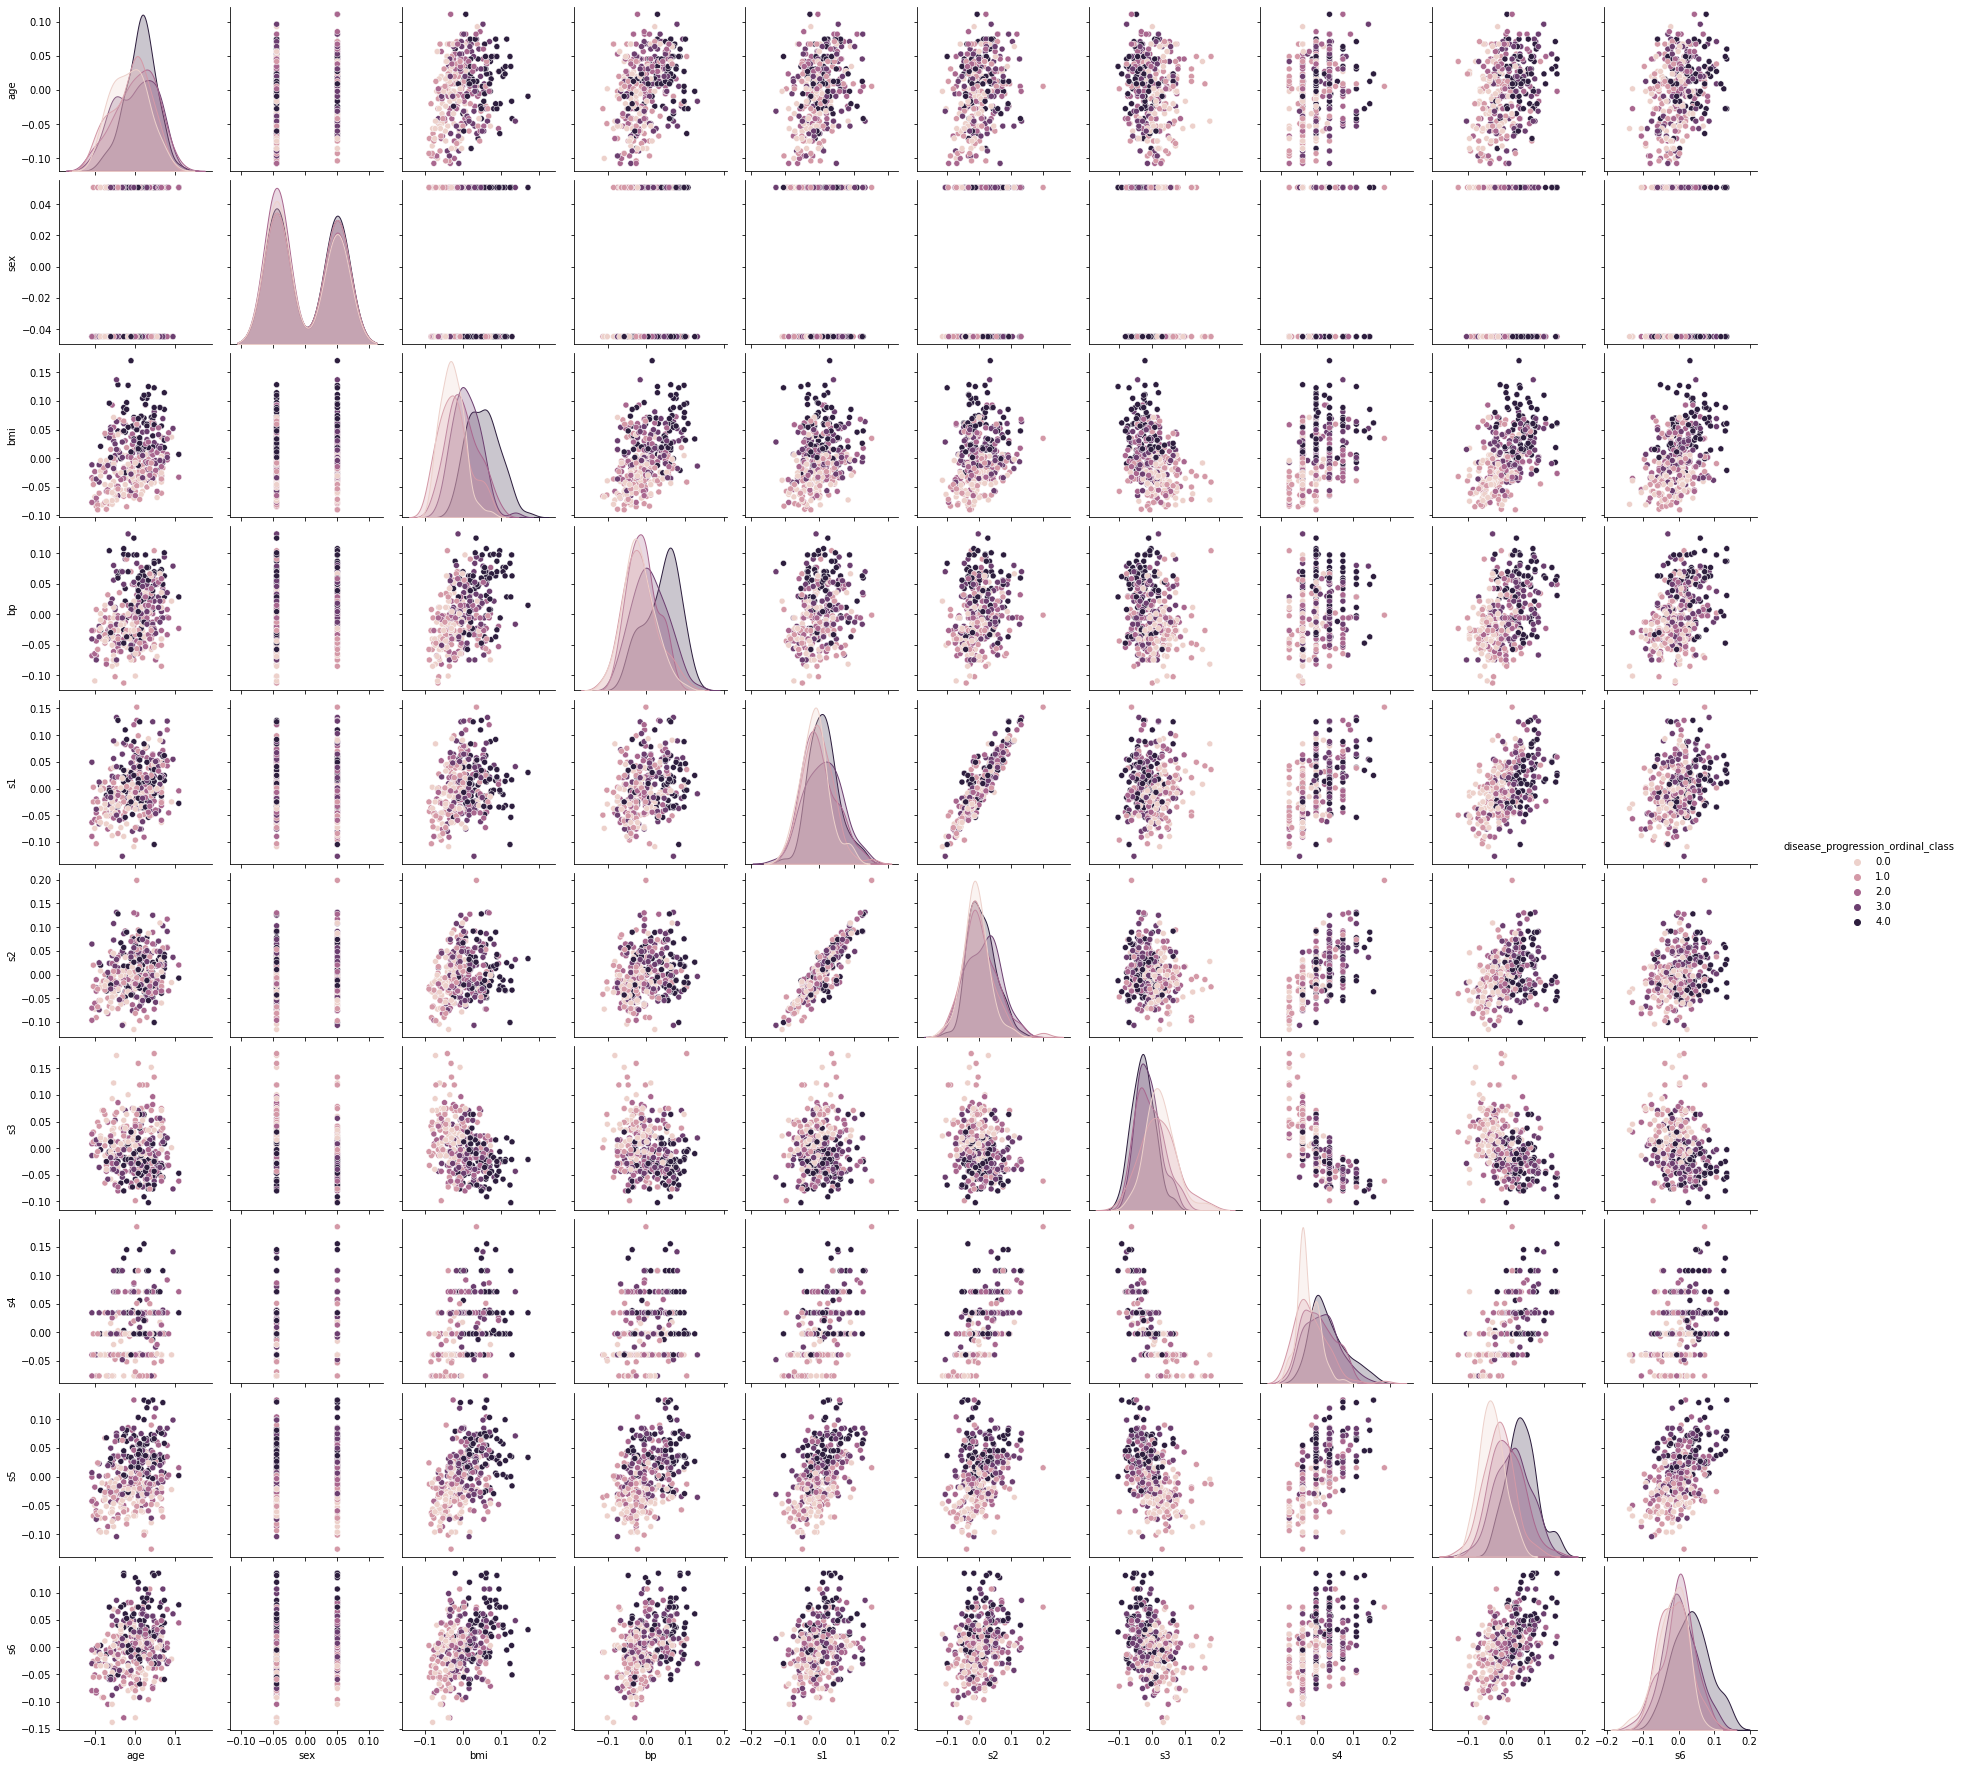

In [8]:
train_data = X_train.copy()
train_data['disease_progression_ordinal_class'] = y_train_ordinal
sns.pairplot(train_data, hue='disease_progression_ordinal_class')

# Ordinal Classification

In [9]:
# Set up the input and dense layer
input = tf.keras.Input(shape=(X_train.shape[-1],), name='Diabetes_Features')
dense_layer = tf.keras.layers.Dense(1, name='Latent_Linear')(input)

# Set up cutpoints layer

random_values = tf.random.normal(shape=(n_classes - 2,))

padding_layer = tfp.layers.VariableLayer(shape=(n_classes - 2,),
                                        activation=tf.math.softplus,
                                        initializer=lambda shape, dtype: 
                                                tfp.util.TransformedVariable(
                                                    initial_value=random_values,
                                                    bijector=tfb.Scale(scale=1.),
                                                    dtype=dtype),
                                        # regularizer=tf.keras.regularizers.l2(),
                                        name='Padding_Variable'
                                        )(input)
ordinal_layer = tfp.layers.DistributionLambda(lambda t: CumulativeLink(loc=t[0], padding=t[1]), name='CLM')([dense_layer, padding_layer])
ordinal_model = tf.keras.Model(inputs=input, outputs=ordinal_layer, name='CLM-PC-HMM')

ordinal_model.compile(optimizer=Adam(lr=0.05), loss=NegativeLogLikelihood())
history = ordinal_model.fit(X_train, y_train_ordinal, epochs=100)

Epoch 1/100
12/12 [==============================] - 0s 2ms/step - loss: 2.0090
Epoch 2/100
12/12 [==============================] - 0s 2ms/step - loss: 1.5565
Epoch 3/100
12/12 [==============================] - 0s 2ms/step - loss: 1.5103
Epoch 4/100
12/12 [==============================] - 0s 2ms/step - loss: 1.4617
Epoch 5/100
12/12 [==============================] - 0s 2ms/step - loss: 1.4308
Epoch 6/100
12/12 [==============================] - 0s 2ms/step - loss: 1.4198
Epoch 7/100
12/12 [==============================] - 0s 2ms/step - loss: 1.4046
Epoch 8/100
12/12 [==============================] - 0s 2ms/step - loss: 1.3820
Epoch 9/100
12/12 [==============================] - 0s 2ms/step - loss: 1.3695
Epoch 10/100
12/12 [==============================] - 0s 2ms/step - loss: 1.3570
Epoch 11/100
12/12 [==============================] - 0s 2ms/step - loss: 1.3486
Epoch 12/100
12/12 [==============================] - 0s 2ms/step - loss: 1.3374
Epoch 13/100
12/12 [=================

<function matplotlib.pyplot.show(close=None, block=None)>

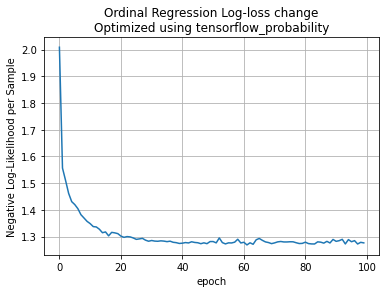

In [10]:
# Plot Training loss
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('Negative Log-Likelihood per Sample')
plt.title('Ordinal Regression Log-loss change\nOptimized using tensorflow_probability')
plt.grid()
plt.show

In [11]:
# Model Summary
tf.print(ordinal_model.summary())
print(ordinal_model.trainable_weights)

Model: "CLM-PC-HMM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Diabetes_Features (InputLayer)  [(None, 10)]         0                                            
__________________________________________________________________________________________________
Latent_Linear (Dense)           (None, 1)            11          Diabetes_Features[0][0]          
__________________________________________________________________________________________________
Padding_Variable (VariableLayer (3,)                 3           Diabetes_Features[0][0]          
__________________________________________________________________________________________________
CLM (DistributionLambda)        ((None, 1), (None, 1 0           Latent_Linear[0][0]              
                                                                 Padding_Variable[0][0]  

In [12]:
# Predictions and probability scores for each dataset
y_train_pred = ordinal_model.predict(X_train)
y_test_pred = ordinal_model.predict(X_test)

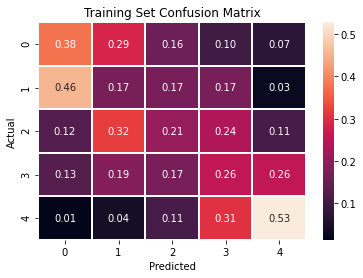

In [13]:
# Training Confusion Matrix
cf_matrix = confusion_matrix(y_train_ordinal, y_train_pred, normalize='true', labels=list(range(n_classes)))

ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
ax.set_title(f'Training Set Confusion Matrix')
plt.show()

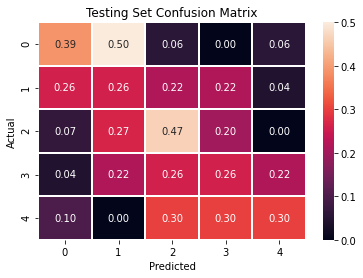

In [14]:
# Testing Confusion Matrix
cf_matrix = confusion_matrix(y_test_ordinal, y_test_pred, normalize='true',labels=list(range(n_classes)))

ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
ax.set_title(f'Testing Set Confusion Matrix')
plt.show()